In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [3]:
# #get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Sound check

In [4]:
# sound check
# do a quick check for sound
# data_exp_24884-v5_task-qgn4.csv
sound = pd.read_csv('data_exp_24884-v5/data_exp_24884-v5_task-qgn4.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)

In [5]:
sound = sound[np.isfinite(sound['button pressed'])]

In [6]:
correct = [1, 0, 0]* 30

In [7]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [8]:
# sound_final

In [9]:
# 1912551

In [10]:

# sound_final.head(300)

# Fish

In [11]:
# import file
data_1 = pd.read_csv('data_exp_24884-v5/data_exp_24884-v5_task-njom.csv', sep = ",")
# data_2 = pd.read_csv("pilot_2/data_exp_24005-v8_task-lhx6.csv", sep = ",")


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# data_1.drop(['Unnamed: 37', 'Unnamed: 39'], axis = 1, inplace = True)


In [13]:
# data = pd.concat([data_1, data_2])

In [14]:
data = data_1

In [15]:
data = data.replace('null', np.nan)
data  = data.replace('nan', np.nan)


In [16]:
data['start_time'] = round(data['start_time'].astype(float))

In [17]:
data.columns

Index(['Event Index', 'UTC Timestamp', 'UTC Date', 'Local Timestamp',
       'Local Timezone', 'Local Date', 'Experiment ID', 'Experiment Version',
       'Tree Node Key', 'Repeat Key', 'Schedule ID', 'Participant Public ID',
       'Participant Private ID', 'Participant Starting Group',
       'Participant Status', 'Participant Completion Code',
       'Participant External Session ID', 'Participant Device Type',
       'Participant Device', 'Participant OS', 'Participant Browser',
       'Participant Monitor Size', 'Participant Viewport Size', 'Checkpoint',
       'Task Name', 'Task Version', 'reaction time', 'key pressed',
       'price_displayed', 'environment', 'task', 'function id', 'builtin rt',
       'end_time', 'start_time', 'response', 'Unnamed: 36', 'round_instance',
       'Unnamed: 38'],
      dtype='object')

In [18]:
data = data[['Participant Private ID', 'UTC Timestamp','key pressed', 'price_displayed', 'environment', 'task', 'function id',
       'builtin rt', 'end_time', 'start_time', 'response', 'round_instance']]


In [19]:
data.rename(columns={"Participant Private ID": "Subject"}, inplace = True)


In [20]:
data = data.sort_values(by = ['Subject', 'start_time'])

In [21]:
data['trial_label'] = data[['environment', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [22]:
# exclude
# data = data[data.Subject != 1912551]

In [23]:
fish = data[(data.task == "fishing_pos")|(data.task == "fishing_neg")]


In [24]:
fish = fish[fish['start_time'].notna()]

In [25]:
fish['start_time'] = fish['start_time'].astype(int)

In [26]:
fish.environment.unique()

array(['pre_mood', 'post_mood'], dtype=object)

In [27]:
fish["environment_binary"] = np.where(fish["environment"] == 'pre_mood', 0, 1)


In [28]:
d = fish.groupby(['Subject','environment_binary', 'round_instance'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')


In [29]:
fish['latency'] = d['latency']
fish = fish.sort_index().sort_values(['Subject', 'start_time'])

In [30]:
fish.head(1)

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency
4,1932451.000,1599581938918.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,1271.600,1599581938564.000,1599581937292,nan,1.000,pre_mood 1.0,0,1376.000


In [31]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

In [32]:
mask = fish.groupby(['Subject', 'environment'])['round_instance'].transform(mask_first).astype(bool)

# data_useful = data_useful.loc[mask]


In [33]:
fish = fish.loc[mask]

In [34]:
fish.head()
fish["mood"] = fish["task"].map({'fishing_pos': "pos", 'fishing_neg':'neg'})


In [35]:
fish.groupby("mood")["Subject"].nunique()

mood
neg    30
Name: Subject, dtype: int64

In [36]:
fish["mood"] = fish["function id"].map({"fishing_pos":"pos",
                                    "fishing_neg":"neg"})

In [37]:
fish['mood'].unique()

array(['neg'], dtype=object)

# graph

In [38]:
mood_graph_pre = fish[(fish.environment == "pre_mood")]
anova = mood_graph_pre.groupby(["Subject", "mood"])['latency'].mean().reset_index(name = "latency")


In [39]:
# ss.f_oneway(anova["latency"][anova["mood"] == "neg"],
#            anova["latency"][anova["mood"] == "pos"])

In [40]:
# mood_graph_pre = fish[(fish.environment == "pre_mood")]
# # p = mood_graph_pre.groupby(["environment","mood","price_displayed"])['latency'].mean().reset_index(name = "latency")
# price = [0.1, 0.6, 2.5, 6.0]
# # latency_pre_p = p.latency[(p.mood == 'pos')]
# latency_pre_n = p.latency[(p.mood == 'neg')]
# sns.lineplot("price_displayed", "latency", marker='o', color='purple', data = mood_graph_pre,label = "negative", err_style='bars')
# # plt.plot( price, latency_pre_p, marker='', color='blue', linewidth=2, label = "positive")
# # plt.plot( price, latency_n_pre, marker='', color='black', linewidth=2, linestyle='dashed', label="negative")
# plt.title("Action Initiation Latency before Mood Manipulation (n = 30)")
# plt.xlabel("Price")
# plt.ylabel("Average Latency (ms)")
# plt.ylim([135, 215])
# plt.legend()
# plt.savefig('price_latency_before_mood.png', transparent=True, dpi=300)


In [41]:
# mood graph
mood_graph = fish[(fish.environment == "post_mood")]
g = mood_graph.groupby(["environment","mood","price_displayed"])['latency'].mean().reset_index()


In [42]:
g

,environment,mood,price_displayed,latency
0,post_mood,neg,0.100,168.867
1,post_mood,neg,0.400,172.266
2,post_mood,neg,1.000,173.622
3,post_mood,neg,2.500,170.095


In [43]:
price = [0.1, 0.6,2.5, 6.0]
# latency_p = g.latency[(g.mood == 'pos')]
latency_n = g.latency[(g.mood == 'neg')]

In [44]:
data.Subject.nunique()

30

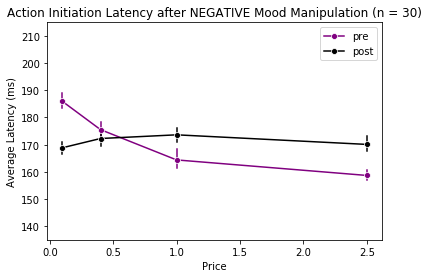

In [45]:
# plt.plot( price,  latency_pre_n, marker='', color='purple', linewidth=2, label = "pre-mood")
# plt.plot( price, latency_n, marker='', color='black', linewidth=2, linestyle='dashed', label="post-mood")

sns.lineplot("price_displayed", "latency", marker='o', color='purple', data = mood_graph_pre,label = "pre", err_style='bars')
sns.lineplot("price_displayed", "latency", marker='o', color='black', data = mood_graph,label = "post", err_style='bars')


plt.title("Action Initiation Latency after NEGATIVE Mood Manipulation (n = 30)")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.ylim([135, 215])
plt.savefig('price_latency_after_NEG_mood.png', transparent=True, dpi=300)


In [46]:
b = mood_graph[mood_graph.Subject != 1932550]
a = mood_graph_pre[mood_graph_pre.Subject != 1932550]

In [53]:
fish[fish.Subject == 1932550].groupby("price_displayed").latency.mean()

price_displayed
0.100    808.000
0.400    777.500
1.000   1700.143
2.500   1456.500
Name: latency, dtype: float64

In [50]:
print (b.Subject.nunique())
b.groupby("price_displayed").latency.mean()

29


price_displayed
0.100   168.628
0.400   172.047
1.000   173.397
2.500   169.542
Name: latency, dtype: float64

In [51]:
mood_graph.groupby("price_displayed").latency.mean()

price_displayed
0.100   168.867
0.400   172.266
1.000   173.622
2.500   170.095
Name: latency, dtype: float64

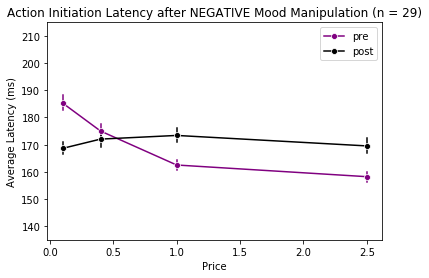

In [48]:
# 193255


sns.lineplot("price_displayed", "latency", marker='o', color='purple', data = a, label = "pre", err_style='bars')
sns.lineplot("price_displayed", "latency", marker='o', color='black', data = b, label = "post", err_style='bars')


plt.title("Action Initiation Latency after NEGATIVE Mood Manipulation (n = 29)")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.ylim([135, 215])
plt.savefig('price_latency_after_NEG_mood_excluded.png', transparent=True, dpi=300)


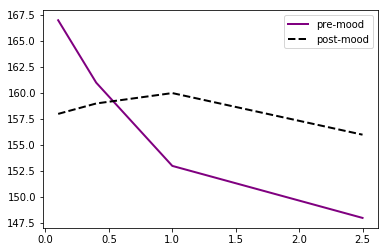

In [141]:
latency_pre_n = mood_graph_pre.groupby(["price_displayed"])["latency"].median()
latency_n = mood_graph.groupby(["price_displayed"])["latency"].median()
price = [0.1, 0.4, 1, 2.5]
plt.plot( price,  latency_pre_n, marker='', color='purple', linewidth=2, label = "pre-mood")
plt.plot( price, latency_n, marker='', color='black', linewidth=2, linestyle='dashed', label="post-mood")

plt.legend()



# Rating

In [59]:
# response
rating = data[(data.task == "mood_rating_pos")|(data.task == "mood_rating_neg")]


In [60]:

rating = rating[rating['response'].notna()]

In [61]:
rating["response"].describe()

count   180.000
mean     65.689
std      22.128
min       5.000
25%      51.000
50%      61.000
75%      86.000
max     100.000
Name: response, dtype: float64

In [62]:
6 * 30

180

In [63]:
rating = rating.sort_values(["Subject", "UTC Timestamp"])

In [64]:
rating["index"]=[1]*len(rating)


In [65]:
i = rating.groupby(["Subject", "environment"])["index"].cumsum().reset_index(name = "index")
rating = pd.merge(rating, i, left_on=rating.index, right_on = "level_0", how = "inner")
rating.head()

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,index_x,level_0,index_y
0,1932451.000,1599581981298.000,nan,nan,pre_mood,mood_rating_neg,caller,nan,nan,nan,84.000,4.000,pre_mood 4.0,1,190,1
1,1932451.000,1599582026390.000,nan,nan,pre_mood,mood_rating_neg,caller,nan,nan,nan,79.000,8.000,pre_mood 8.0,1,444,2
2,1932451.000,1599582076863.000,nan,nan,pre_mood,mood_rating_neg,caller,nan,nan,nan,63.000,12.000,pre_mood 12.0,1,685,3
3,1932451.000,1599582155897.000,nan,nan,post_mood,mood_rating_neg,caller,nan,nan,nan,60.000,15.000,post_mood 15.0,1,954,1
4,1932451.000,1599582203654.000,nan,nan,post_mood,mood_rating_neg,caller,nan,nan,nan,54.000,15.000,post_mood 15.0,1,1221,2


In [66]:
rating.drop(["index_x", "level_0"], axis = 1, inplace = True)

In [67]:
rating["mood"] = rating["task"].map({"mood_rating_pos":"pos",
                                    "mood_rating_neg":"neg"})

In [68]:
rating["name"] = rating["Subject"].astype(int).astype(str) + " " + rating["mood"]


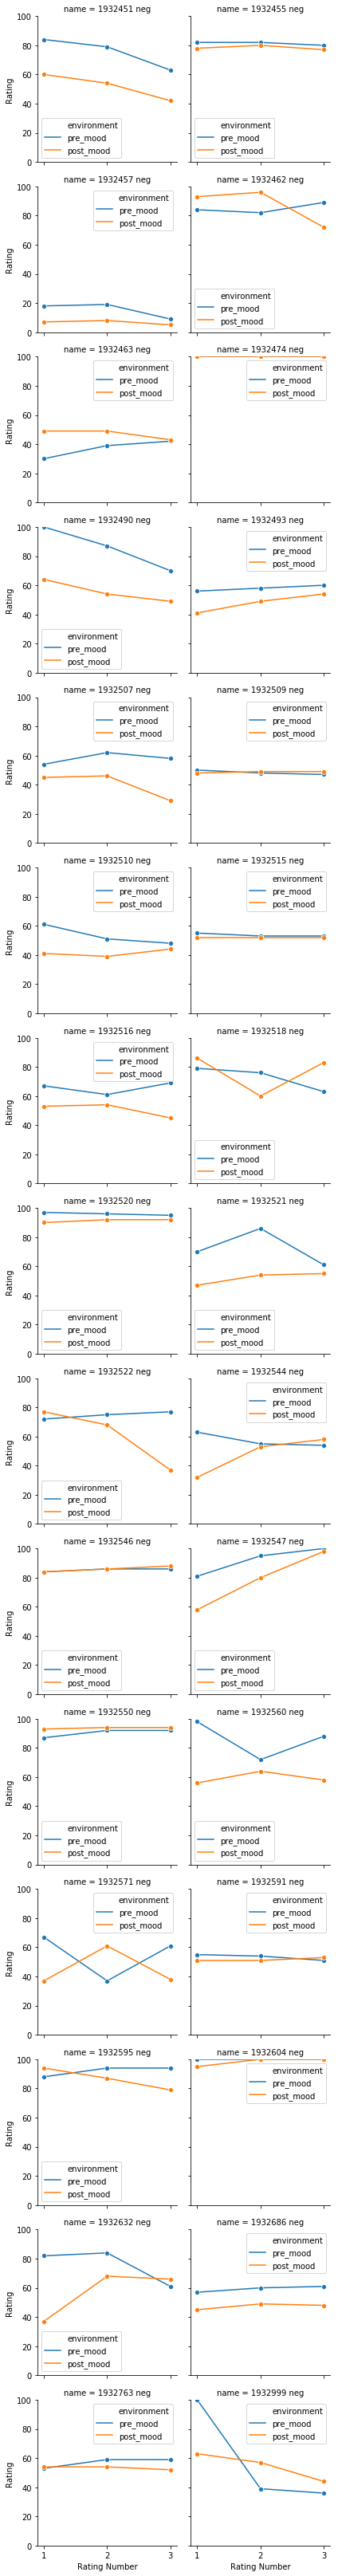

In [69]:
r = sns.FacetGrid(rating, col="name", col_wrap=2, height=3, ylim=(0, 100))
r.map(sns.lineplot, "index_y", "response", "environment", marker="o")
for ax in r.axes.ravel():
    ax.legend()
    ax.set_ylabel("Rating")
    ax.set_xlabel("Rating Number")
    
# plt.xlabel("Rating Number")
# plt.ylabel("Rating Number")
plt.xticks([1, 2, 3])
plt.savefig("rating_by_subject_NEG.png", transparent=True, dpi=300)
# g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(50, 300))
# g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "GnBu_d", legend = 'full',
#       err_style="bars")



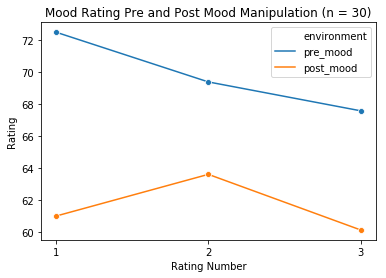

In [70]:
sns.lineplot("index_y", "response", "environment", markers=True, ci = None,marker = "o", data = rating)
plt.xlabel("Rating Number")
plt.ylabel("Rating")
plt.xticks([1, 2, 3])
plt.title("Mood Rating Pre and Post Mood Manipulation (n = 30)")
plt.savefig("NEG mood raitng", dpi = 300, transparent = True)

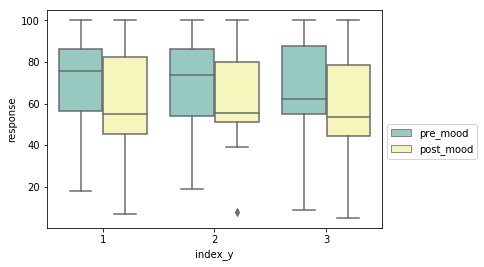

In [71]:
ax = sns.boxplot(x="index_y", y="response", hue="environment",
                 data=rating, palette="Set3")
ax.legend(loc = 1, bbox_to_anchor = (1.3, 0.5))
plt.savefig("rating_boxplot.png", dpi = 300, transparent = True, bbox_inches='tight')

In [61]:
# b = sns.FacetGrid(rating, col="mood", col_order=["pos", "neg"])
# b = b.map(sns.lineplot, "index_y", "response","environment", markers=True, ci = None)
# plt.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True)
# axes = b.axes.flatten()
# axes[0].set_title("mood = pos (n = 13)")
# axes[1].set_title("mood = neg (n = 16)")
    
# plt.savefig("average_rating_29.png", transparent = True, dpi = 300, bbox_inches='tight')

In [62]:
# b = sns.FacetGrid(rating[rating.Subject != 1912556], col="mood", col_order=["pos", "neg"])
# b = b.map(sns.lineplot, "index_y", "response","environment", markers=True, ci = None)
# plt.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True)
# axes = b.axes.flatten()
# axes[0].set_title("mood = pos (n = 12)")
# axes[1].set_title("mood = neg (n = 16)")
    
# plt.savefig("average_rating_28.png", transparent = True, dpi = 300, bbox_inches='tight')


# Look at neg and pos seperately?

In [63]:
fish.head()

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency,mood
5,1932451.000,1599581939262.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,184.950,1599581938854.000,1599581938668,nan,1.000,pre_mood 1.0,0,289.000,neg
6,1932451.000,1599581939418.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,14.760,1599581938972.000,1599581938957,nan,1.000,pre_mood 1.0,0,117.000,neg
7,1932451.000,1599581939418.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,48.420,1599581939122.000,1599581939074,nan,1.000,pre_mood 1.0,0,153.000,neg
8,1932451.000,1599581939793.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,95.305,1599581939323.000,1599581939227,nan,1.000,pre_mood 1.0,0,200.000,neg
9,1932451.000,1599581940121.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,310.810,1599581939738.000,1599581939427,nan,1.000,pre_mood 1.0,0,418.000,neg


In [64]:
# b = sns.FacetGrid(fish, col="mood", col_order=["pos", "neg"])
# b = b.map(sns.lineplot, "price_displayed", "latency", "environment",
#          err_style = "bars")
# plt.tight_layout()
# plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True)

# plt.savefig("average_latency_pos_neg.png", transparent = True, dpi = 300, 
#             bbox_inches='tight')
# plt.show()

# by subject plot

In [72]:
fish.head(1)
# fish["title"] = fish["Subject"].astype(str) + " " + fish["mood"]

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency,mood
5,1932451.000,1599581939262.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,184.950,1599581938854.000,1599581938668,nan,1.000,pre_mood 1.0,0,289.000,neg


In [73]:
# f = fish.groupby(["title", "environment", "price_displayed"])["latency"].mean().reset_index(name = "avg")

In [74]:
sum_rating = rating.groupby(["Subject", "environment"])["response"].mean().reset_index(name = "avg_rating")

In [75]:
sum_rating["diff"] = sum_rating.groupby("Subject")["avg_rating"].diff(periods=-1)

In [76]:
sum_rating = sum_rating.dropna()

In [77]:
fish = fish.merge(sum_rating[["Subject", "diff"]], on = "Subject", how = "left")

In [78]:
fish = fish.sort_values(by = "diff")

In [79]:
fish["title"] = fish["Subject"].astype(str) + " diff: " + fish["diff"].round(2).astype(str)

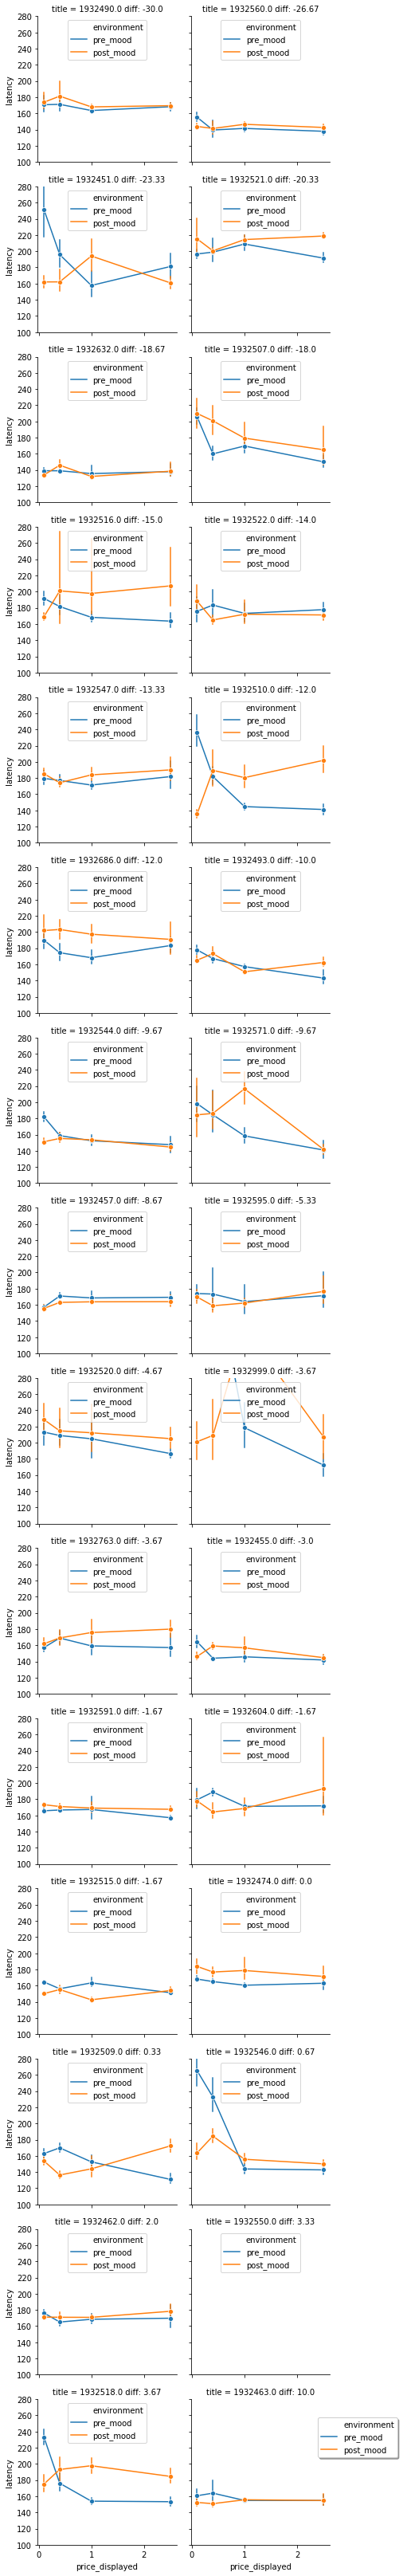

In [80]:
r = sns.FacetGrid(fish, col="title", col_wrap=2, height=3, ylim = ([100, 280]))
r.map(sns.lineplot, "price_displayed", "latency", "environment", marker="o", err_style='bars', hue_order = ["pre_mood", "post_mood"])
for ax in r.axes.ravel():
    ax.legend(loc='upper center')
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True)
plt.savefig("latency_by_subject_ordered_NEG.png", transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 1932550

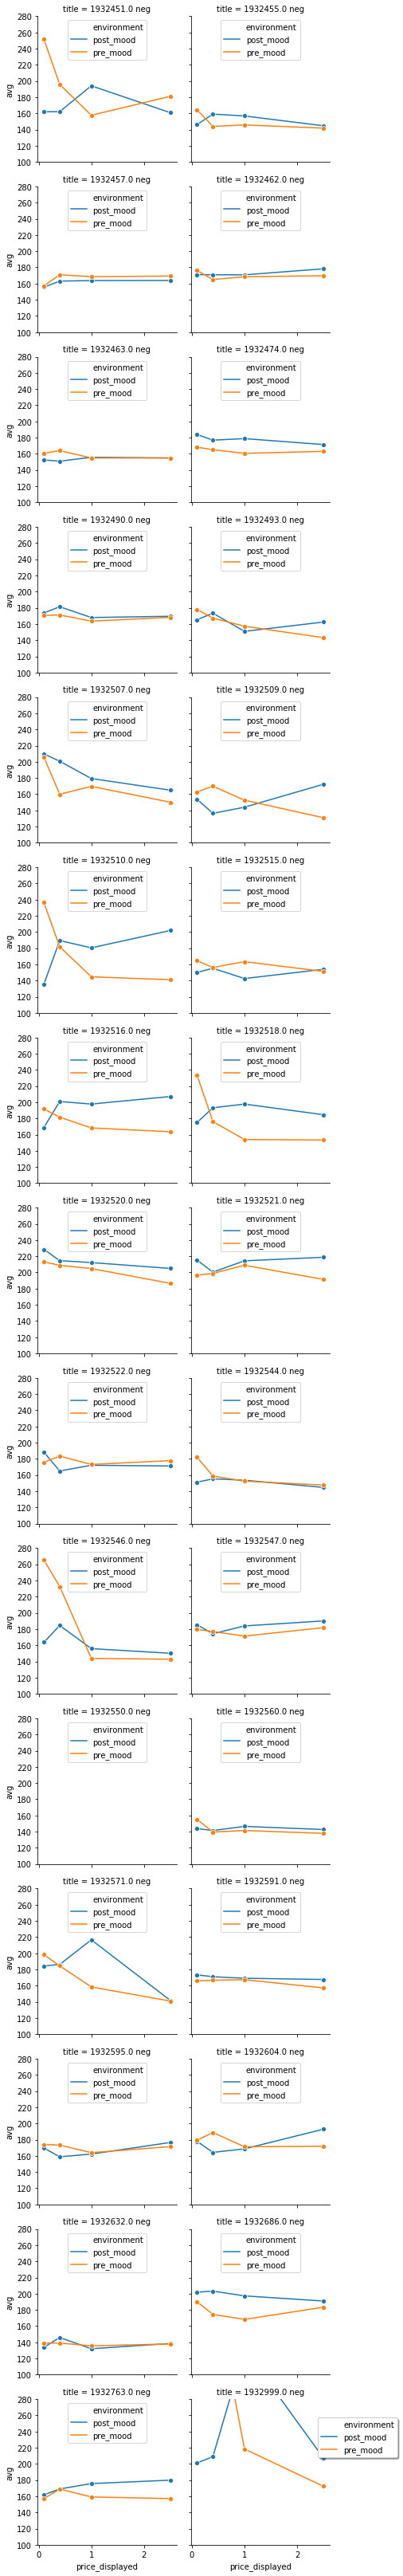

In [113]:
r = sns.FacetGrid(f, col="title", col_wrap=2, height=3, ylim = ([100, 280]))
r.map(sns.lineplot, "price_displayed", "avg", "environment", marker="o")
for ax in r.axes.ravel():
    ax.legend(loc='upper center')
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True)
plt.savefig("latency_by_subject_NEG.png", transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# tap difference

In [81]:
tap = fish.groupby(["Subject", "environment"]).size().reset_index(name = "tap")

In [82]:
t = tap.groupby("Subject").tap.diff(periods = -1)

In [83]:
tap["tap_diff"] = t

In [84]:
tap = tap.dropna()

In [85]:
rating_tap_diff = pd.merge(sum_rating, tap[["Subject", "tap_diff"]], on = "Subject")

In [86]:
ss.spearmanr(rating_tap_diff["diff"], rating_tap_diff["tap_diff"])

SpearmanrResult(correlation=0.08336115800099134, pvalue=0.6614222432513891)

# Mood change and HPS

In [87]:
hps = pd.read_csv("hps_neg.csv")

In [88]:
hps = hps.merge(rating_tap_diff, on = "Subject")

In [89]:
ss.spearmanr(hps["score"], hps["diff"])

SpearmanrResult(correlation=-0.2330995251178172, pvalue=0.21510450423434024)

In [90]:
ss.pearsonr(hps["score"], hps["tap_diff"])

(0.20437346728282718, 0.2786665137611366)

# median latency between high and low

In [82]:
fish.Subject.nunique()

30

In [83]:
m = fish.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [84]:
m = m[m.price_displayed.isin([0.1, 2.5])]

In [85]:
diff = m.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [86]:
m["diff"] = diff

In [87]:
m = m.dropna()

In [88]:
np.median(m["diff"]*(-1))

9.0

In [89]:
# only pre-mood

In [90]:
m_pre_mood = fish[fish.environment == "pre_mood"]

In [91]:
m_pre_mood = m_pre_mood.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [92]:
m_pre_mood = m_pre_mood[m_pre_mood.price_displayed.isin([0.1, 2.5])]

In [93]:
diff_pre_mood = m_pre_mood.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [94]:
m_pre_mood["diff"] = diff_pre_mood

In [95]:
m_pre_mood = m_pre_mood.dropna()

In [96]:
np.median(m_pre_mood["diff"]*(-1))

11.5

In [97]:
f_1 = fish[fish.trial_label.isin(['pre_mood 1.0',
                                 'pre_mood 2.0',
                                 'pre_mood 3.0',
                                 'pre_mood 4.0'])]



In [98]:
f_2 = fish[fish.trial_label.isin(['pre_mood 5.0',
                                 'pre_mood 6.0',
                                 'pre_mood 7.0',
                                 'pre_mood 8.0'])]

In [99]:
m_pre_mood_1 = f_1.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")
m_pre_mood_1 = m_pre_mood_1[m_pre_mood_1.price_displayed.isin([0.1, 6])]
diff_pre_mood_1 = m_pre_mood_1.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_pre_mood_1["diff"] = diff_pre_mood_1
m_pre_mood_1 = m_pre_mood_1.dropna()
np.median(m_pre_mood_1["diff"]*(-1))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [129]:
m_pre_mood_2 = f_2.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")
m_pre_mood_2 = m_pre_mood_2[m_pre_mood_2.price_displayed.isin([0.1, 6])]
diff_pre_mood_2 = m_pre_mood_2.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_pre_mood_2["diff"] = diff_pre_mood_2
m_pre_mood_2 = m_pre_mood_2.dropna()
np.median(m_pre_mood_2["diff"]*(-1))


27.5

In [130]:
from scipy import stats as ss

In [131]:
ss.ttest_rel(m_pre_mood_2["diff"], m_pre_mood_1["diff"])

Ttest_relResult(statistic=0.5036211665131262, pvalue=0.6184670833033181)

In [101]:
# post-mood overall

In [110]:
m_post_mood = fish[fish.environment == "post_mood"]

In [111]:
m_post_mood.shape

(19940, 17)

In [112]:
m_post_mood = m_post_mood.groupby(["Subject","price_displayed"])["latency"].median().reset_index(name = "median")
m_post_mood = m_post_mood[m_post_mood.price_displayed.isin([0.1, 2.5])]
diff_post_mood = m_post_mood.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)
m_post_mood["diff"] = diff_post_mood
m_post_mood = m_post_mood.dropna()
np.median(m_post_mood["diff"]*(-1))

0.5

In [182]:
# post-mood positive

In [193]:
m_pos = fish[(fish.mood == "pos")&(fish.environment == "post_mood")]

In [194]:
m_pos = m_pos.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [195]:
m_pos= m_pos[m_pos.price_displayed.isin([0.1, 6])]

In [196]:
diff_pos_mood = m_pos.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [197]:
m_pos["diff"] = diff_pos_mood

In [198]:
m_pos = m_pos.dropna()

In [199]:
np.median(m_pos ["diff"]*(-1))

1.0

In [202]:
m_post_mood = fish[fish.environment == "post_mood"]

In [203]:
m_neg = m_post_mood[m_post_mood.mood == "neg"]

In [204]:
m_neg = m_neg.groupby(["Subject", "price_displayed"])["latency"].median().reset_index(name = "median")

In [205]:
m_neg= m_neg[m_neg.price_displayed.isin([0.1, 6])]

In [206]:
diff_neg_mood = m_neg.groupby(["Subject"], as_index = True)["median"].diff().shift(-1)

In [207]:
m_neg["diff"] = diff_neg_mood

In [208]:
m_neg = m_neg.dropna()

In [209]:
np.median(m_neg ["diff"]*(-1))

0.5

# Log Linear Mixed Model

In [38]:
from statsmodels.formula.api import mixedlm

In [39]:
# calculate fatigue
fish["tap_count"] = [1] * len(fish)
tap_count = fish.groupby(['Subject', 'trial_label'])['tap_count'].cumsum().reset_index(name = "fatigue")
tap_count = tap_count.reset_index().set_index("index")
tap_count = tap_count.drop("level_0", axis = 1)

In [40]:
fish = tap_count.merge(fish, left_index = True, right_index = True, how = "inner")

In [41]:
fish["log_latency"] = np.log(fish["latency"])

In [42]:
fish.environment_binary.unique()

array([0, 1])

In [43]:
fish.price_displayed.unique()

array([2.5, 1. , 0.1, 0.4])

In [45]:
fish.latency.isnull().values.any()
fish = fish[fish.latency.notnull()]

In [46]:
fish.head(1)

,fatigue,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency,mood,tap_count,log_latency
5,1,1932451.000,1599581939262.000,40.000,2.500,pre_mood,fishing_neg,fishing_neg,184.950,1599581938854.000,1599581938668,nan,1.000,pre_mood 1.0,0,289.000,neg,1,5.666


In [47]:
fish_pre = fish[fish.environment == "pre_mood"]
fish_post = fish[fish.environment == "post_mood"]


In [104]:
f_model = mixedlm(formula = "log_latency ~ 1 + environment_binary + price_displayed + fatigue",
                 groups = fish["Subject"],
                 re_formula = "~ environment_binary + price_displayed + fatigue", data = fish)
r = f_model.fit(reml = False, method = "powell")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [105]:
print (r.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         log_latency
No. Observations:           39451           Method:                     ML         
No. Groups:                 30              Scale:                      0.0574     
Min. group size:            23              Likelihood:                 144.2077   
Max. group size:            1713            Converged:                  Yes        
Mean group size:            1315.0                                                 
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 5.216    0.058 89.493 0.000  5.102  5.330
environment_binary                       -0.006    0.014 -0.450 0.653 -0.034  0.021
price_displayed

In [109]:
r_params = pd.DataFrame(r.params, columns = ["LMM"])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index = str, columns = {"group":"LMM"})

In [111]:
f_pre = mixedlm(formula = "log_latency ~ 1 + price_displayed + fatigue",
                 groups = fish_pre["Subject"],
                 re_formula = "~ price_displayed + fatigue", data = fish_pre)
r_pre = f_pre.fit(reml = False, method = "powell")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [112]:
print (r_pre.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      log_latency
No. Observations:      19870        Method:                  ML         
No. Groups:            30           Scale:                   0.0541     
Min. group size:       12           Likelihood:              601.7692   
Max. group size:       855          Converged:               Yes        
Mean group size:       662.3                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      5.246    0.064 81.917 0.000  5.121  5.372
price_displayed               -0.053    0.014 -3.703 0.000 -0.081 -0.025
fatigue                       -0.001    0.000 -2.962 0.003 -0.002 -0.000
Group Var                      0.122    0.146                        

In [114]:
f_post = mixedlm(formula = "log_latency ~ 1 + environment + price_displayed + fatigue",
                 groups = fish_post["Subject"],
                 re_formula = "~ environment + price_displayed + fatigue", data = fish_post)
r_post = f_post.fit(reml = False, method = "powell")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [115]:
print (r_post.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      log_latency
No. Observations:       19581        Method:                  ML         
No. Groups:             30           Scale:                   0.0572     
Min. group size:        11           Likelihood:              66.1158    
Max. group size:        858          Converged:               Yes        
Mean group size:        652.7                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      5.176    0.044 118.507 0.000  5.090  5.261
price_displayed                0.006    0.011   0.527 0.598 -0.015  0.026
fatigue                       -0.002    0.001  -2.749 0.006 -0.003 -0.000
Group Var                      0.057    0.067           

In [48]:
f_pre_avg = fish_pre.groupby("Subject")["latency"].mean().reset_index(name = "avg_across")
f_post_avg = fish_post.groupby("Subject")["latency"].mean().reset_index(name = "avg_across")
                                                                      

In [49]:
ss.wilcoxon(f_pre_avg.avg_across, f_post_avg.avg_across)

WilcoxonResult(statistic=199.0, pvalue=0.49079849348995086)

In [56]:
f_pre_avg = fish_pre.groupby("Subject")["latency"].median().reset_index(name = "avg_across_pre")
f_post_avg = fish_post.groupby("Subject")["latency"].median().reset_index(name = "avg_across_post")
                                                                      

In [58]:
ss.wilcoxon(f_pre_avg.avg_across_pre, f_post_avg.avg_across_post)

WilcoxonResult(statistic=188.5, pvalue=0.36509377246560404)

In [59]:
medians = f_pre_avg.merge(f_post_avg, on = "Subject")

In [60]:
medians.shape

(30, 3)

In [63]:
m = medians[medians.Subject != 1932550]

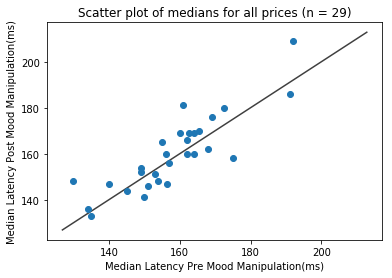

In [74]:
plt.scatter(m["avg_across_pre"], m["avg_across_post"])
plt.xlabel("Median Latency Pre Mood Manipulation(ms)")
plt.ylabel("Median Latency Post Mood Manipulation(ms)")

lims = [
    np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
    np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.title("Scatter plot of medians for all prices (n = 29)")
plt.savefig("scatter plot medians.png", dpi = 300, transparent = True)

In [76]:
ss.wilcoxon(m["avg_across_pre"], m["avg_across_post"])

WilcoxonResult(statistic=158.5, pvalue=0.20165471306805094)